<img src="./logo_UNSAM.jpg" align="right" width="150" />

#### Análisis y Procesamiento de Señales

# Trabajo Práctico Nº7
## Filtrado digital lineal de ECG
#### Tobías Domenech

## Introducción

En el siguiente trabajo se procederá al análisis y filtrado de una señal generada por un electrocardiograma (ECG). Para ello se diseñarán e implementarán filtros digitales de tipo **IIR** (Infinite Impulse Response) y **FIR** (Finite Impulse Response).

Los FIR (o no recursivos), cuyas respuesta en frecuencia fue analizada en trabajos anteriores, se caracterizan por su estabilidad (dada la ubicación de sus polos siempre en el 0 del plano Z) y la posibilidad de poseer una respuesta de fase lineal (entendiendose esto como un retardo de grupo constante, hecho fundamental en el trabajo con señales biológicas como la del ECG dado que no se produce una distorsión temporal de la señal). Por otro lado, este tipo de filtros demandará una gran costo computacional dado que, para cumplir con los requerimientos establecidos por la plantilla de diseño, se precisará de un orden elevado de complejidad. En este caso, se utilizarán los dos tipos de funciones para el diseño de filtros FIR: a) No iterativo: utilizandose, en este caso, el **método de ventanas** (el cual garantiza siempre la obtención de un filtro digital ante una plantilla de diseño válida); b) Iterativos: usandose los métodos de **cuadrados mínimos** y **Parks-McClellan**.

En el caso de los IIR (filtros recursivos) se subsana la problemática del costo computacional, pudiendose cumplir con los requisitos de la plantilla con un orden (cantidad de coeficientes) mucho menor que la exigida por los filtros FIR. No obstante, si bien el diseño de estos filtros resulta más sencillo utilizando el software de Spyder a través de la función iirdesign de Scipy, la implementación de estos filtros trae aparejada dificultades como: estabilidad no garantizada, distorsión de fase (la cual puede será anulada a travé de la implementación del filtrado bidireccional de la señal) y problemas de implementación asociados a la recursividad (exigirá una mayor precisión de la aritmética y de los coeficientes para evitar la rápida propagación de los errores que harían imposible la implementación de estos filtros). A su vez, un IIR con un orden mayor a 9 no suele ser implementable directamente por los problamas numéricos que trae aperajada la recursividad, por lo que se utilizará la metodología de Second Order Section (SOS; "seccionar en bloques de orden 2 el filtro") para ganar estabilidad y evitar la propagación de errores. En el diseño de estos filtros se utilizarán las funciones de aproximación de maxima planicidad de tipo **Cauer** (también conocida como de funciones elípticas) y **Chebyshev** (en particular, se implementará la función cheby1 brindada por Scipy).

A continuación se denotan los requerimientos para generar la plantilla de diseño de los filtros con tal de mitigar la contaminación en la señal del ECG; se verifica la respuesta en frecunecia de los filtros mediante la comparación con la plantilla; se procede al filtrado de la señal ECG por los distintos métodos y se contrastan los resultados obtenidos.

## Plantilla de Diseño

En el caso de la señal de ECG que se utiliza en este trabajo, las fuentes de contaminación son:
- Ruido causado por el movimiento de los electrodos (Alta frecuencia).
- Ruido muscular (Alta frecuencia).
- Movimiento de la línea de base del ECG, inducido en parte por la respiración (Baja frecuencia).

Por lo tanto, el trabajo de los filtros será mitigar ruido tanto de alta como de baja frecuencia.
En el trabajo anterior, se verificó que el límite derecho del ancho de banda para esta señal de ECG ronda los 35 Hz. Teniendo en cuenta el ruido de baja frecuencia inducido por la respiración, se puede estimar que este se encuentra por debajo de 1 Hz. De forma tal que la plantilla se establecerá como:

fstop1 = 0.1 Hz

fpass1 = 1 Hz

fpass2 = 35 Hz

fstop2 = 50 HZ -> (La frecuencia de stop 2, que marca el inicio de la banda de stop, incluye a la frecuencia que puede generar interferen proveniente de la red eléctrica)

Ripple = 1 dB

Atenuación = 40 dB

El ripple es la máxima atenuación aceptada en la banda de paso (de 1 a 35 Hz) y la atenuación es, valga la redundancia, la mínima atenuación deseada en las bandas de stop.

## Diseño de Filtros (y filtrado de señal)

In [1]:
import sympy as sp
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
from pytc2.sistemas_lineales import plot_plantilla
import scipy.io as sio


# REQUERIMIETNOS PLANTILLA
# Normalizada en Nyquist

fs = 1000 # Hz
fs_norma = 2
nyq_frec = fs/2
 
fpass = np.array( [1.0, 35.] )
ripple = 1 # dB alfamax
fstop = np.array( [0.1, 50.] )
atenuacion = 40 # dB alfamin
 
# DATOS ECG

mat_struct = sio.loadmat('./ECG_TP4.mat')
ecg = mat_struct['ecg_lead'].flatten()

ecg = ecg/np.std(ecg) # Normalizo la señal

regs_interes = (
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        ) # CON RUIDO

regs_interes_sin_ruido = (
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        ) # SIN RUIDO

### Filtros IIR

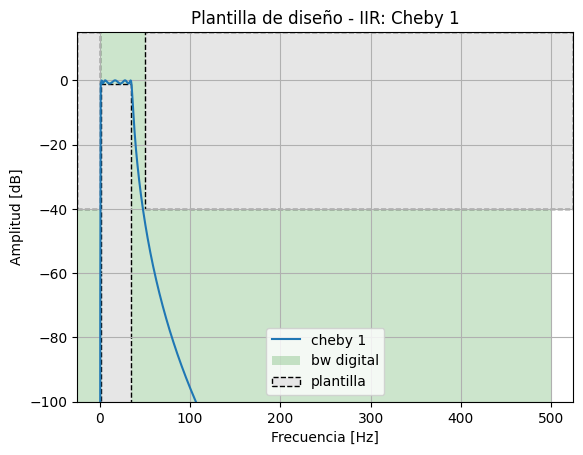

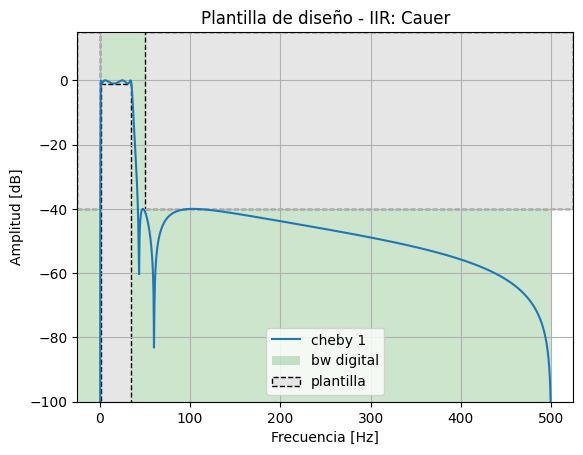

In [4]:
###############
# FILTROS IIR #
###############

# Utilizo de aproximación de Chebyshev y Cauer 


# Análisis filtro

npoints = 1000

##########
# CHEBY 1#
##########
    
sos_cheby1 = sig.iirdesign(fpass, fstop, ripple, atenuacion, ftype = 'cheby1', output= 'sos', fs = fs) 
      
w_ch1, hh_ch1 = sig.sosfreqz(sos_cheby1, worN = npoints)

plt.figure(1)
plt.plot(w_ch1/np.pi*nyq_frec, 20*np.log10(np.abs(hh_ch1)+1e-15), label='cheby 1')


plt.title('Plantilla de diseño - IIR: Cheby 1')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud [dB]')
plt.grid(which='both', axis='both')

ax = plt.gca()

plot_plantilla(filter_type = 'bandpass' , fpass = fpass, ripple = ripple , fstop = fstop, attenuation = atenuacion, fs = fs)
plt.show()

ecg_filt_ch1 = sig.sosfiltfilt(sos_cheby1, ecg)

##########
# CAUER#
##########

sos_ellip = sig.iirdesign(fpass, fstop, ripple, atenuacion, ftype = 'ellip', output= 'sos', fs = fs) 
      
w_ellip, hh_ellip = sig.sosfreqz(sos_ellip, worN = npoints)

plt.figure(2)
plt.plot(w_ellip/np.pi*nyq_frec, 20*np.log10(np.abs(hh_ellip)+1e-15), label='cheby 1')


plt.title('Plantilla de diseño - IIR: Cauer')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud [dB]')
plt.grid(which='both', axis='both')

ax = plt.gca()

plot_plantilla(filter_type = 'bandpass' , fpass = fpass, ripple = ripple , fstop = fstop, attenuation = atenuacion, fs = fs)
plt.show()

ecg_filt_cauer = sig.sosfiltfilt(sos_ellip, ecg)

### Filtros FIR

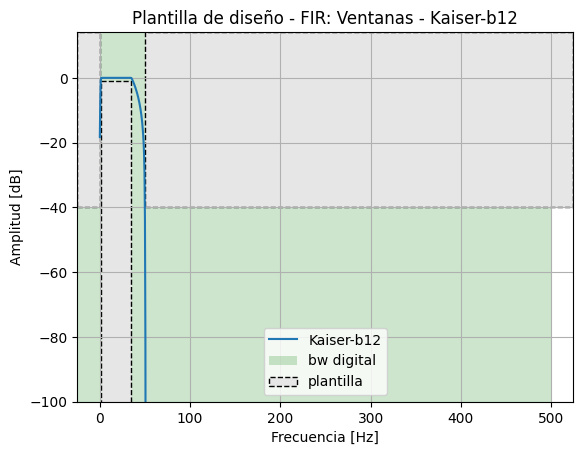

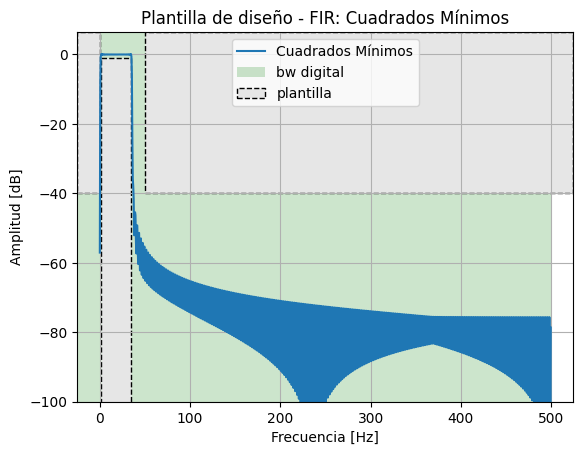

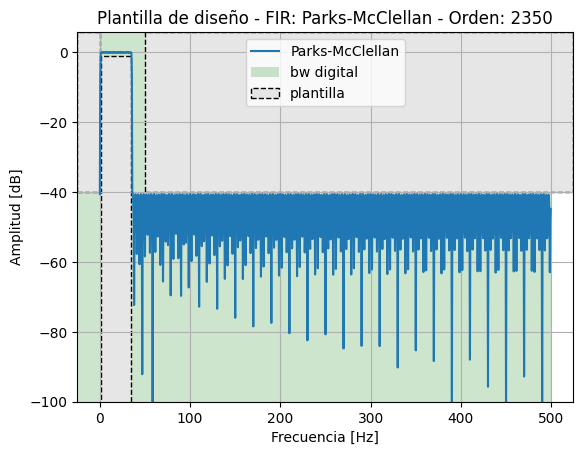

In [6]:
###############
# FILTROS FIR #
###############

#############################################
# Método de ventanas; uso ventana de Kaiser.#
#############################################

cant_coef = 4501

npoints = 1000

frecs_ventanas = np.array([0.0, fstop[0], fpass[0], fpass[1], fstop[1], nyq_frec])
gains_ventanas = np.array([0, 0, 1, 1, 0, 0 ])

coef_ventanas = sig.firwin2(cant_coef, frecs_ventanas, gains_ventanas , window=('kaiser',12), fs = fs)

w_win, h_win = sig.freqz(coef_ventanas, worN= npoints)

plt.figure(3)

plt.plot(w_win/np.pi*nyq_frec, 20*np.log10(np.abs(h_win)+1e-15), label='Kaiser-b12')

plt.title('Plantilla de diseño - FIR: Ventanas - Kaiser-b12')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud [dB]')
plt.grid(which='both', axis='both')

ax = plt.gca()


plot_plantilla(filter_type = 'bandpass' , fpass = fpass, ripple = ripple , fstop = fstop, attenuation = atenuacion, fs = fs)
plt.show()

ecg_filt_ventanas = sig.convolve(ecg,coef_ventanas, mode='same')

############################
# Méto de cuadrados mínimos#
############################


cant_coef_ls = 1501

frecs_ls = np.array([0.0,         fstop[0],   fpass[0],  fpass[1],     fpass[1]+1,  nyq_frec  ]) # Hago simétrico con fpass[1]+1
gains_ls = np.array([0,0,1,1,0,0])


coef_numerador_ls = sig.firls(cant_coef_ls, frecs_ls, gains_ls, fs = fs)

w_ls, h_ls = sig.freqz(coef_numerador_ls, worN= npoints)

plt.figure(4)

plt.plot(w_ls/np.pi*nyq_frec, 20*np.log10(np.abs(h_ls)+1e-15), label='Cuadrados Mínimos')

plt.title('Plantilla de diseño - FIR: Cuadrados Mínimos')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud [dB]')
plt.grid(which='both', axis='both')

ax = plt.gca()


plot_plantilla(filter_type = 'bandpass' , fpass = fpass, ripple = ripple , fstop = fstop, attenuation = atenuacion, fs = fs)
plt.show()

ecg_filt_ls = sig.convolve(ecg, coef_numerador_ls, mode='same')

#############################
# Método de Parks-McClellan #
#############################

cant_coef_remez = 2351

frecs_remez = np.array([0.0, fstop[0], fpass[0], fpass[1],  fpass[1]+1,  nyq_frec  ]) # Hago simétrico con fpass[1]+1
gains_remez = np.array([0,0,1,1,0,0])

coef_numerador_remez = sig.remez(numtaps= cant_coef_remez, bands= frecs_remez, desired= gains_remez[::2], fs = fs)

w_remez, h_remez = sig.freqz(coef_numerador_remez, worN= npoints)

plt.figure(5)

plt.plot(w_remez/np.pi*nyq_frec, 20*np.log10(np.abs(h_remez)+1e-15), label='Parks-McClellan')

plt.title('Plantilla de diseño - FIR: Parks-McClellan - Orden: {}'.format(cant_coef_remez-1))
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud [dB]')
plt.grid(which='both', axis='both')

ax = plt.gca()


plot_plantilla(filter_type = 'bandpass' , fpass = fpass, ripple = ripple , fstop = fstop, attenuation = atenuacion, fs = fs)
plt.show()

ecg_filt_remez = sig.convolve(ecg, coef_numerador_remez, mode='same')

## Representación del funcionamiento de filtrado

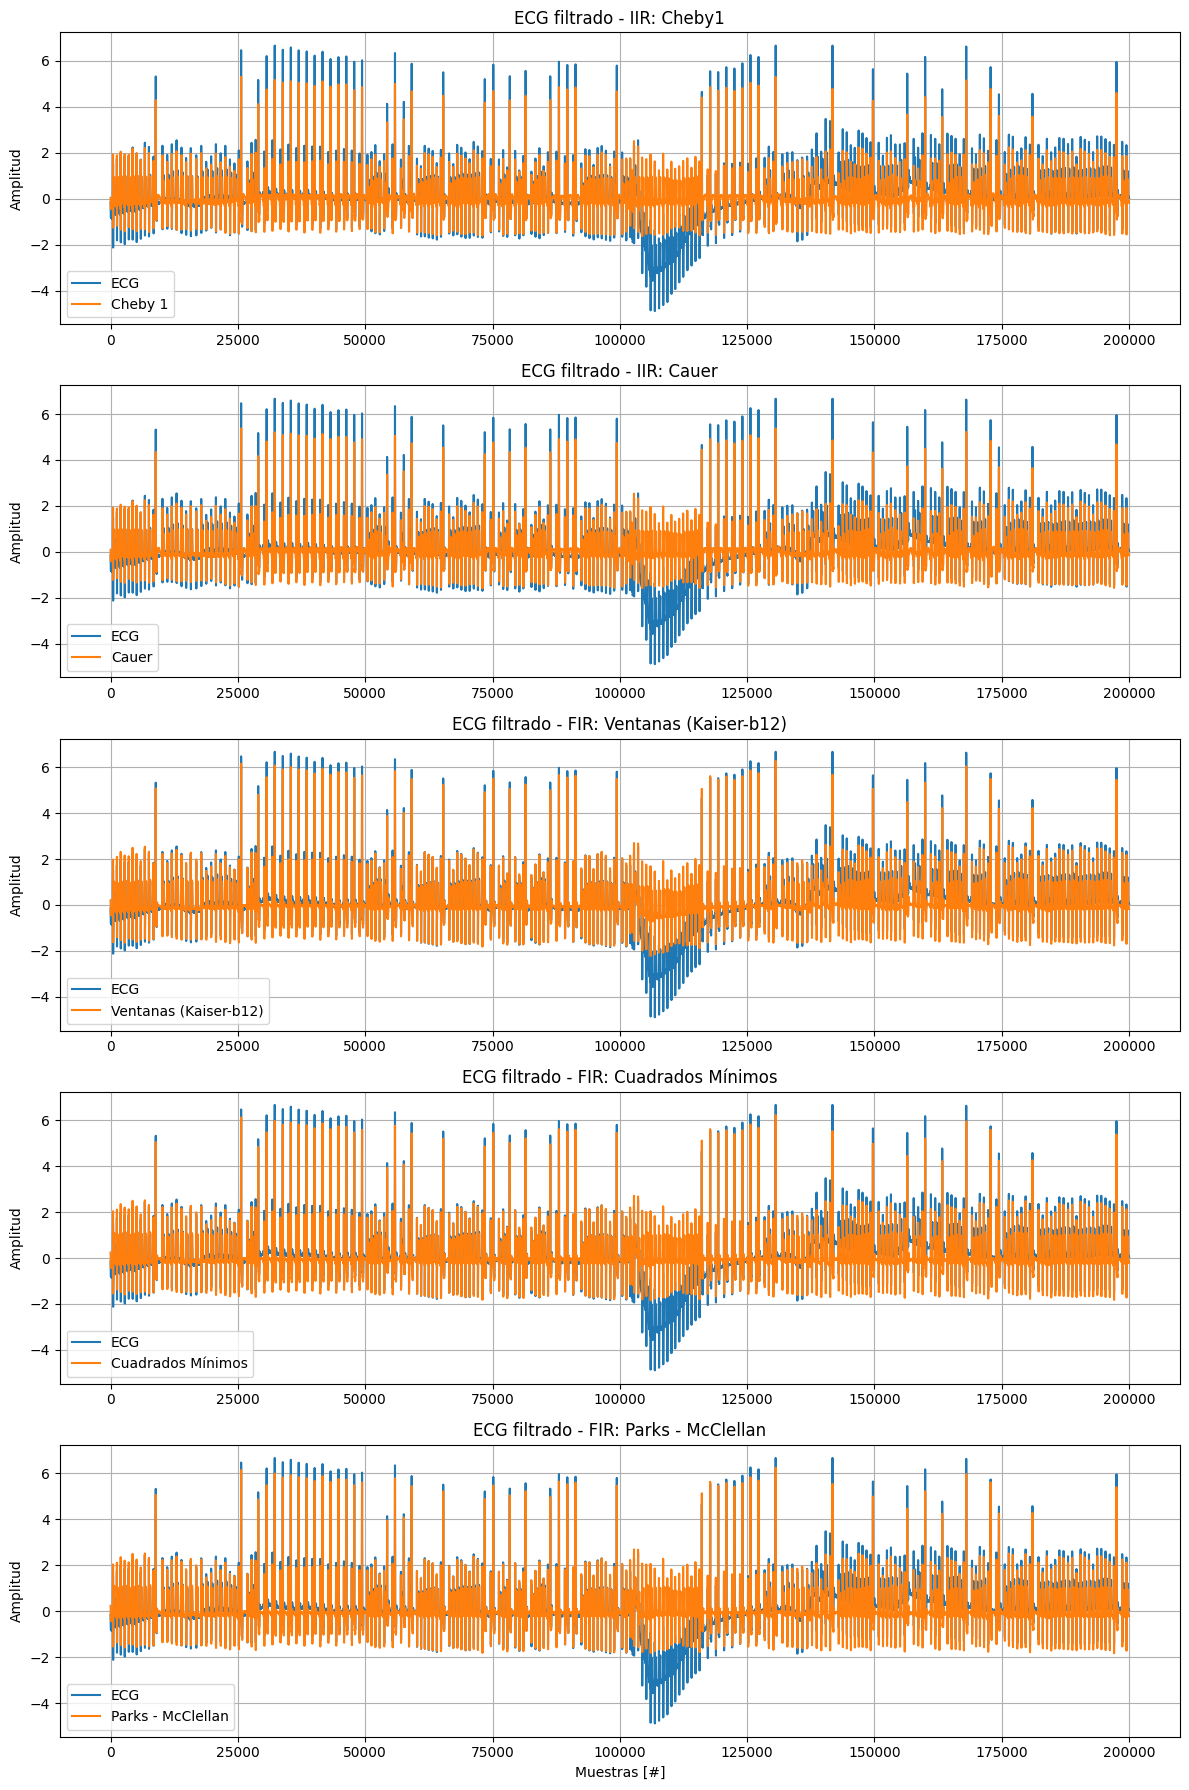

In [7]:
# Gráficos de ECG pasado por los distintos filtros


plt.figure(6,figsize=(12, 18))

plt.subplot(5,1,1)
plt.plot(ecg[0:200000], label = 'ECG')
plt.plot(ecg_filt_ch1[0:200000], label = 'Cheby 1')
plt.ylabel('Amplitud')
plt.title('ECG filtrado - IIR: Cheby1')
plt.legend()
plt.grid(True)

plt.subplot(5,1,2)
plt.plot(ecg[0:200000], label = 'ECG')
plt.plot(ecg_filt_cauer[0:200000], label = 'Cauer')
plt.ylabel('Amplitud')
plt.title('ECG filtrado - IIR: Cauer')
plt.legend()
plt.grid(True)

plt.subplot(5,1,3)
plt.plot(ecg[0:200000], label = 'ECG')
plt.plot(ecg_filt_ventanas[0:200000], label = 'Ventanas (Kaiser-b12)')
plt.ylabel('Amplitud')
plt.title('ECG filtrado - FIR: Ventanas (Kaiser-b12)')
plt.legend()
plt.grid(True)

plt.subplot(5,1,4)
plt.plot(ecg[0:200000], label = 'ECG')
plt.plot(ecg_filt_ls[0:200000], label = 'Cuadrados Mínimos')
plt.ylabel('Amplitud')
plt.title('ECG filtrado - FIR: Cuadrados Mínimos')
plt.legend()
plt.grid(True)

plt.subplot(5,1,5)
plt.plot(ecg[0:200000], label = 'ECG')
plt.plot(ecg_filt_remez[0:200000], label = 'Parks - McClellan')
plt.xlabel('Muestras [#]')
plt.ylabel('Amplitud')
plt.title('ECG filtrado - FIR: Parks - McClellan')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Regiones de Interés

C:\Users\Tobi\AppData\Local\Temp\ipykernel_14808\1705384344.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


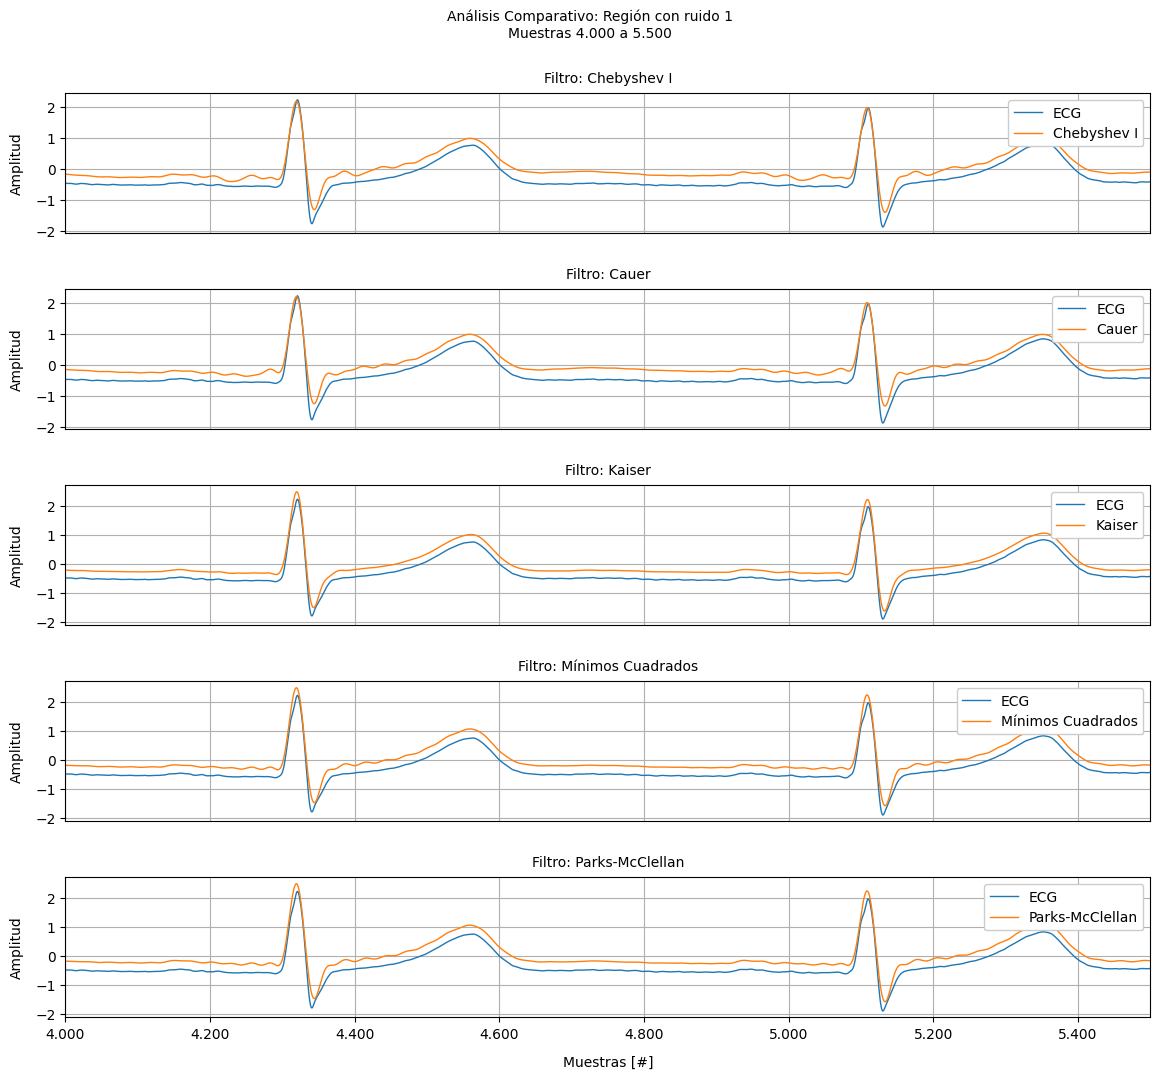

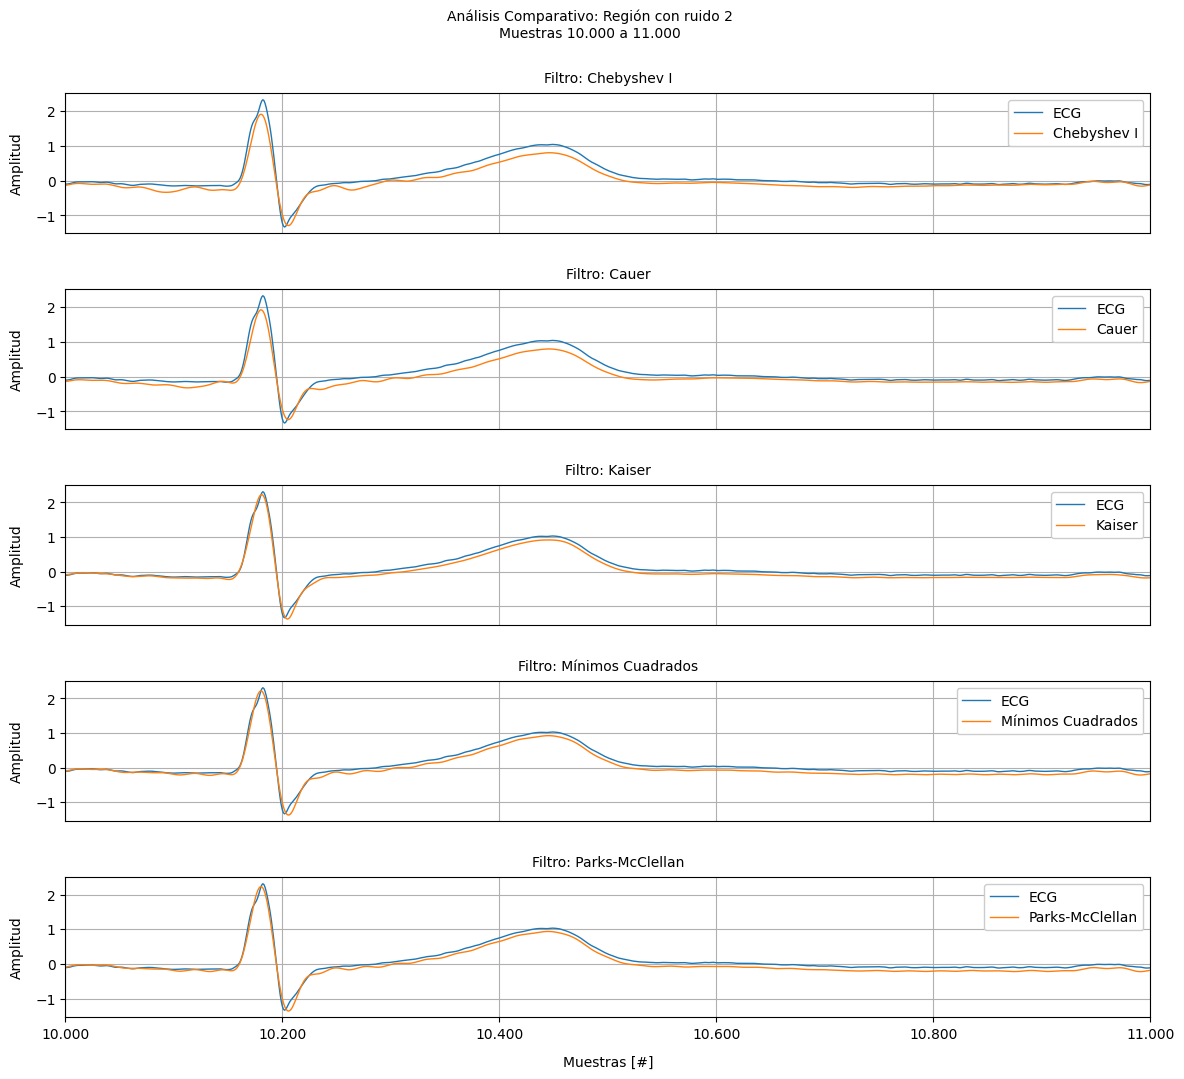

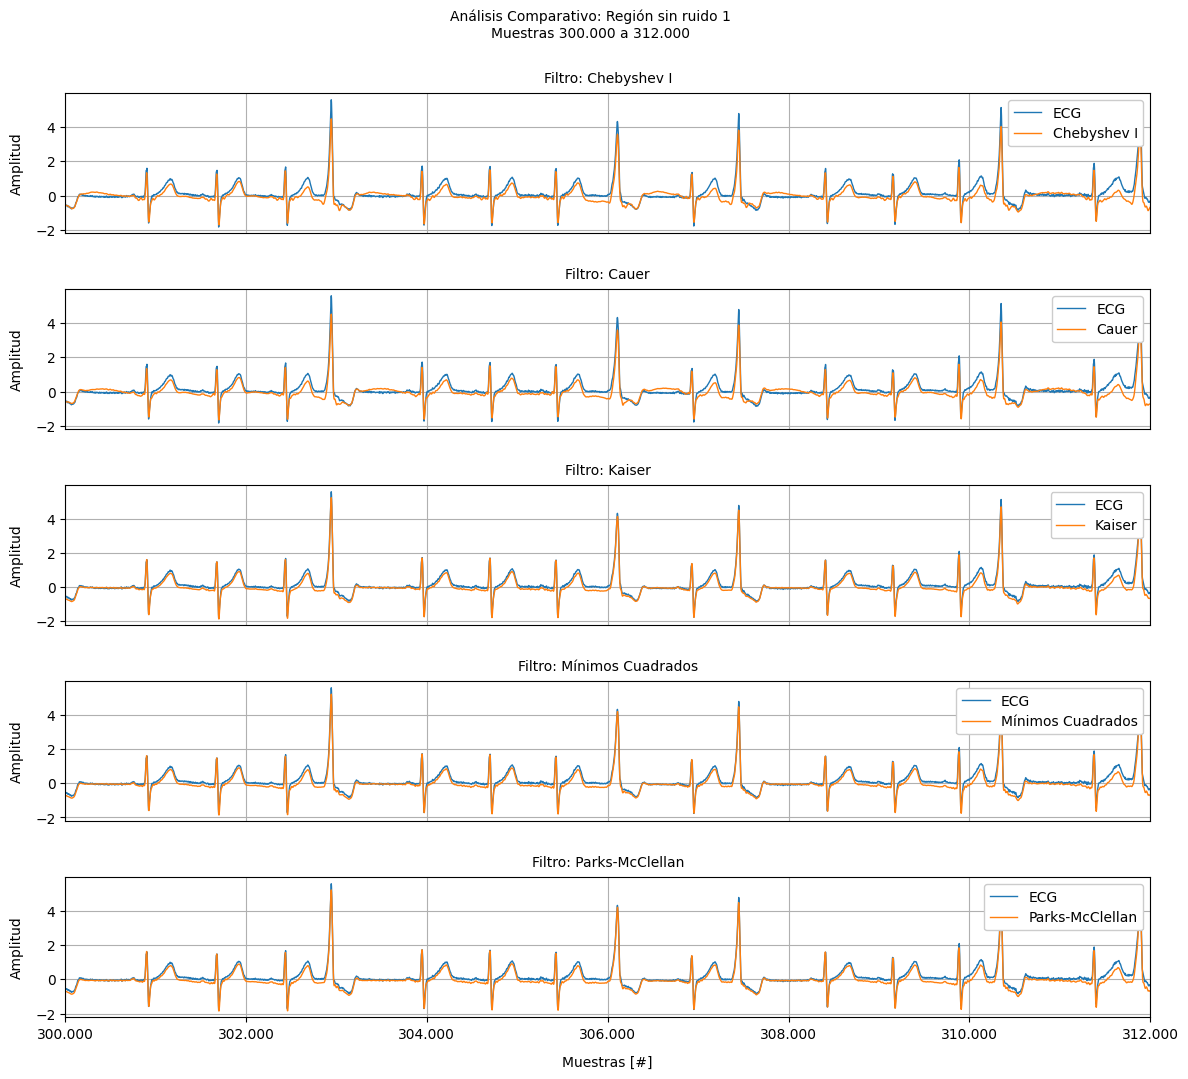

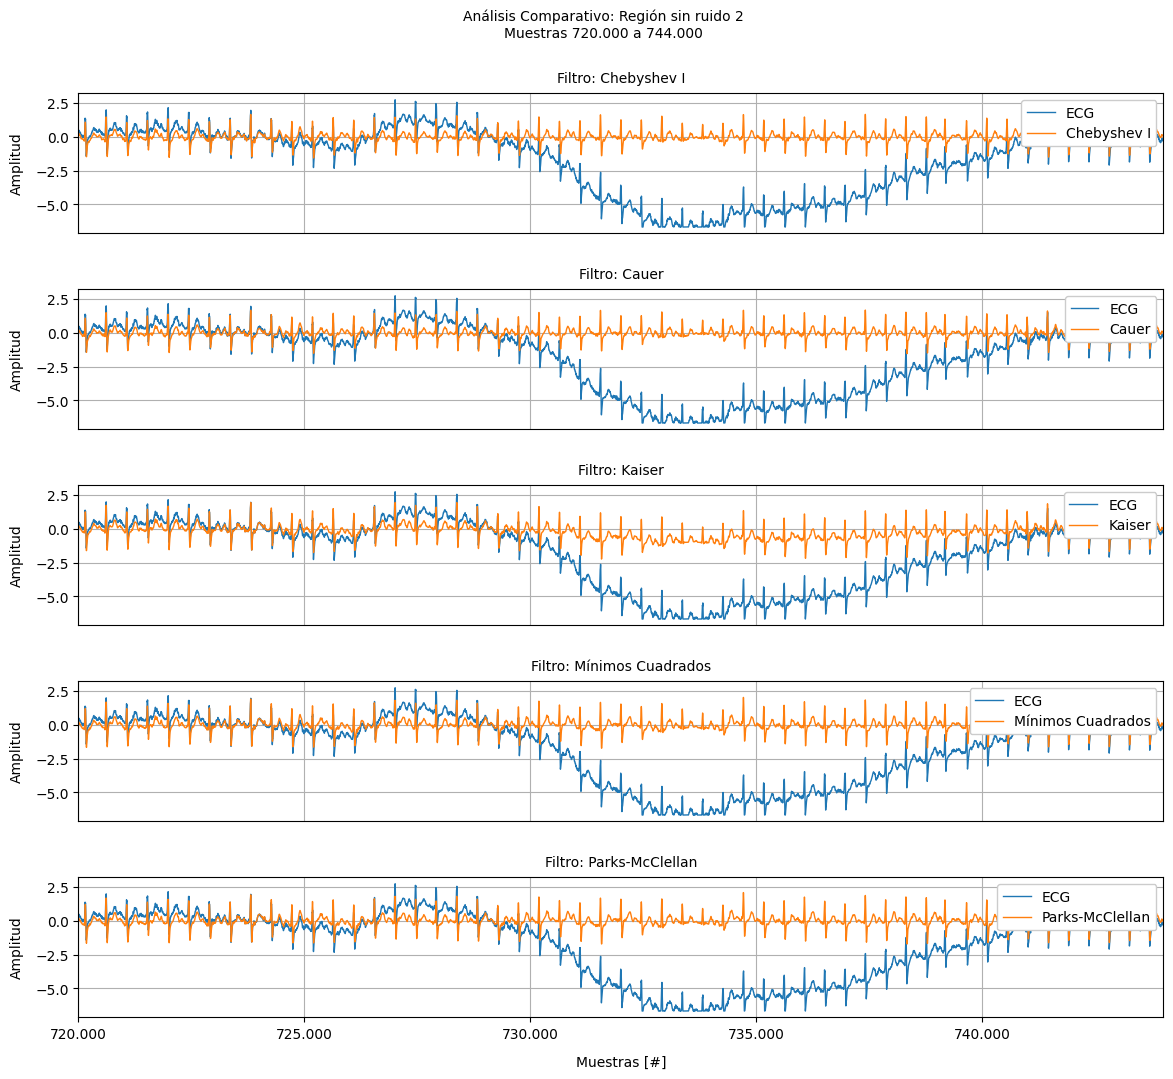

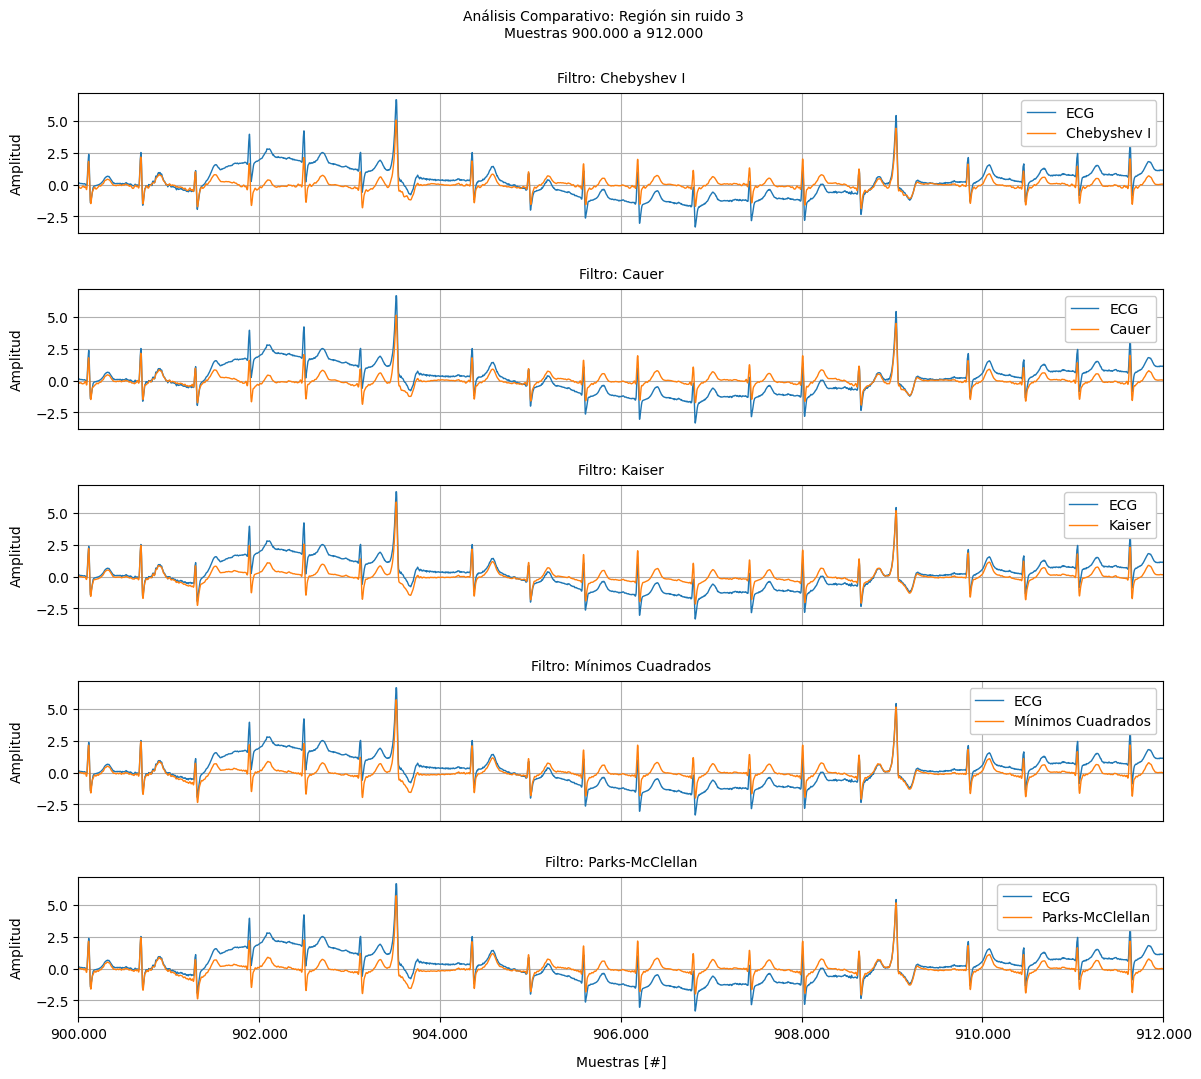

In [8]:
# Asegurar que las regiones sean enteros
regs_interes_sin_ruido_int = [(int(start), int(end)) for start, end in regs_interes_sin_ruido]

import matplotlib.pyplot as plt
import numpy as np


def plot_region_comparison(original, filters_dict, region, title_suffix):
  
    start, end = map(int, region)
    samples = np.arange(start, end)
    
    fig = plt.figure(figsize=(14, 12), facecolor='white')
    fig.suptitle(f"Análisis Comparativo: {title_suffix}\nMuestras {start:,} a {end:,}".replace(',', '.'),
                y=0.95, fontsize=10)
    
    # Crear subplots con espacio optimizado
    gs = fig.add_gridspec(5, 1, hspace=0.4)
    axs = [fig.add_subplot(gs[i]) for i in range(5)]
    
    for idx, (name, filtered) in enumerate(filters_dict.items()):
        ax = axs[idx]
        ax.plot(samples, original[start:end], lw = 1,  label='ECG')
        ax.plot(samples, filtered[start:end], lw = 1, label=name)
        
        # Configuración profesional del subplot
        ax.set_title(f"Filtro: {name}", pad=8, fontsize= 10)
        ax.set_xlim(start, end)
        ax.set_ylabel('Amplitud', labelpad=8)
        ax.legend(loc='upper right', framealpha=1)
        ax.grid(True)
        
        # Formateo de ejes profesional
        
        # Ocultar ticks y etiquetas del eje X en todos excepto el último subplot
        if idx < 4:
           ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
        else:
           ax.set_xlabel('Muestras [#]', labelpad=10)
           ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', '.')))
    
    plt.tight_layout()
    plt.show()

# Diccionario de filtros 
filters = {
    'Chebyshev I': ecg_filt_ch1,
    'Cauer': ecg_filt_cauer,
    'Kaiser': ecg_filt_ventanas,
    'Mínimos Cuadrados': ecg_filt_ls,
    'Parks-McClellan': ecg_filt_remez
}

# Procesamiento de regiones CON ruido

for i, region in enumerate(regs_interes, 1):
    plot_region_comparison(ecg, filters, region, f"Región con ruido {i}")

# Procesamiento de regiones SIN ruido

for i, region in enumerate(regs_interes_sin_ruido, 1):
    plot_region_comparison(ecg, filters, region, f"Región sin ruido {i}")

## Resultados y Conclusiones

### Diseño

Si bien todos los filtros diseñados lograron cumplir con lo requerimientos de la plantilla de diseño, se denota claramente la gran diferencia entre los IIR y FIR: mientras que los primeros no presentan mayores dificultades a la hora de su diseño y cumplimiento de los requerimientos, los FIR exigen varias modificaciones (como la simetrización de las frecuencias y variación de las ganancias) asi como uno número mucho mayor de iteraciones para lograr cumplir con las exigencias de esta plantilla.

### Funcionamiento

En lo que respecta a la señal general del ECG, los gráficos denotan que todos los filtros lineales aquí aplicados lograron el cometido de mitigar las interferencias de alta y baja frecuencia presentes en la señal (eficiencia), y logran mantener la la señal inocua dentro de la banda de paso.

Apreciando las regiones de interés es posible notar con mayor claridad la eficiencia de los filtros de tipo IIR en la remoción del ruido de alta frecuencia (notandose una mayor selectividad por parte de Cauer por sobre Cheby tipo 1 dado por la mayor pendiente de atenuación en la banda de transición de la respuesta en frecuencia). Cabe destacar que a ambos filtros IIR se les realiza el proceso de filtrado bidireccional para eliminar la distorsión de fase. En las regiones sin afección de ruido es notoria la mejor inocuidad de los filtros FIR (en particular el de la Ventana de Kaiser) en los puntos de transiciones abruptas (como lo son los latidos ectópicos). Este hecho puede deberse al la gran planicidad en su respuesta de frecuencia en la banda de paso, permitiendole preservar la morfología de la señal, hehco importante al trabajr con señales biológicas como el ECG.

Por lo tanto, los filtros aquí utilizados han demostrado su utilidad en el tratamiento de la señal de ECG. En base a los resultados obtenidos, podría utilizarse un filtro de tipo IIR (como el de Cauer), con su filtrado bidireccional, para obtener una señal limpia con un costo computacional menor. O, también, teniendo los recaudos necesarios, la opción de un filtro de tipo FIR diseñado por el método de la ventana de Kaiser ha de ser de gran utilidad gracias a su planicidad en la respuesta de frecuencia dentro de la banda de paso y a su respuesta de fase lineal, permitiendo obtener la menor distorsión posible de la señal original.